#### Resampling Methods Lab

Primarily $3$ Methods will be covered here : 
- `Validation Set` approach
- `Cross Validation` approach
- `Bootstrap` approach

Cross validation is mostly used to estimate the test error rates in both quantitative and qualitative situations. <br> 
Bootstrap is mostly used to estimate the variance of the estimated parameters - basically to quantify the uncertainity in parameters. 

In [115]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly )
from sklearn.model_selection import train_test_split, cross_validate, KFold, ShuffleSplit
from ISLP.models import sklearn_sm
from sklearn.base import clone
from functools import partial

## Code used explanation

1. `train_test_split()` → arguments are test_size, random_state, to split the data into training and testing

A and B are two functions, then to use A(B(Data)), we need a wrapper `sklearn_sm()` which allows us to use the CV tools of `sklearn` with models fit by `statsmodels`

2. `sklearn_sm()` → arguments are model_str & model_args
3. `cross_validate()` → arguments are fit(), predict() & score()
4. `ShuffleSplit()` → easily implement cross validation and validation set approach

In [8]:
data = load_data("Auto")
d_train, d_validate = train_test_split(data, test_size=196, random_state=0)

In [25]:
# Fitting a simple OLS model
x_train = MS(["horsepower"]).fit_transform(d_train)
y_train = d_train["mpg"]
x_validate = MS(["horsepower"]).fit_transform(d_validate)
y_validate = d_validate["mpg"]

model = sm.OLS(y_train, x_train).fit()
preds = model.predict(x_validate)
np.mean((y_validate - preds) ** 2)

23.61661706966988

In [148]:
# Writing this in a function form
def evalMSE(terms, response, test_size, data) : 
    mm = MS(terms)
    d_train, d_validate = train_test_split(data, test_size = test_size)
    x_train = mm.fit_transform(d_train)
    x_validate = mm.fit_transform(d_validate)
    y_train = d_train[response]
    y_validate = d_validate[response]

    model = sm.OLS(y_train, x_train).fit()
    preds = model.predict(x_validate)
    mse = np.mean((y_validate - preds) ** 2)
    return mse

# If you run this continously, you will get the distribution of the mse.
evalMSE(["horsepower"], "mpg", 196, data)

import sys

mse_results = []
for i in range(1000):
    if i % 100 == 0:
        progress = f"\rProgress is {i/100:.0f}%"
        sys.stdout.write(progress)
    mse_results.append(evalMSE(["horsepower"], "mpg", 196, data))

# Print a newline at the end to avoid overwriting
print()

Progress is 9%


In [144]:
def evalMSE(terms, response , train , test):
    mm = MS(terms)
    X_train = mm.fit_transform(train) 
    y_train = train[response]
    X_test = mm.transform(test) 
    y_test = test[response]
    results = sm.OLS(y_train, X_train).fit()
    test_pred = results.predict(X_test)
    return np.mean((y_test - test_pred)**2)

Auto_train, Auto_valid = train_test_split(data, test_size=196,random_state = 3)
MSE = np.zeros(3)
for idx, degree in enumerate(range(1, 4)):
    MSE[idx] = evalMSE([poly('horsepower', degree)], 'mpg', Auto_train, Auto_valid)
MSE

array([20.75540796, 16.94510676, 16.97437833])

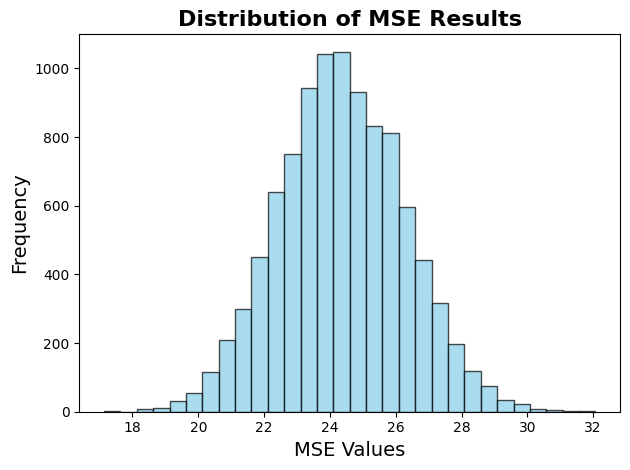

In [129]:
import matplotlib.pyplot as plt
plt.hist(mse_results, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of MSE Results", fontsize=16, fontweight='bold')
plt.xlabel("MSE Values", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout() 
plt.show()

As we can see that the MSE Values are highly variable depending on the data - which is one of the problem with `validation set` approach, the other problem is that it doesn't include the validation data for training hence grossly overestimating the test error

In [159]:
# Cross Validation
hp_model = sklearn_sm(sm.OLS, MS(['horsepower']))
x,y = data.drop(columns = ["mpg"]), data["mpg"]

cv_results = cross_validate(hp_model, x, y, cv = data.shape[0])
cv_err = np.mean(cv_results["test_score"])
cv_err

24.23151351792924

In [164]:
# Using the KFold Function
cv_error = np.zeros(5)
cv = KFold(n_splits = 10, shuffle = True, random_state = 0)
h = np.array(data["horsepower"])
m = sklearn_sm(sm.OLS)

for i, d in enumerate(range(1,6)) : 
    x = np.power.outer(h, np.arange(d+1))
    m_cv = cross_validate(m,x,y, cv = cv)
    cv_error[i] = np.mean(m_cv["test_score"])

cv_error

array([24.20766449, 19.18533142, 19.27626666, 19.47848403, 19.13720581])

Sharp drop in MSE from 24.20 to 19.18, seems that quadratic fit is good.

In [170]:
# Implementation of ShuffleSplit

validation = ShuffleSplit(n_splits = 10, test_size = 196, random_state = 0)
results = cross_validate(hp_model,
                         data.drop(["mpg"],axis =1),
                         data["mpg"],
                         cv = validation)
np.mean(results['test_score']), results["test_score"].std()

(23.802232661034168, 1.421845094109185)

Here, the standard deviation is not a valid estimate of sampling variability because of the correlations introduced by overlap in the samples. 